Artificial Neural Networks
================

------
**Deep Learning for Computer Vision**

(c) Research Group CAMMA, University of Strasbourg

Website: http://camma.u-strasbg.fr/

-----

### About this notebook

- **Objectives**: 
  - Train and test simple ANNs
  - Experiment with underfitting / overfitting
  - Perform experiments on Spiral3 and MNIST

### Neural Networks for Classification of Spiral3 Toy Dataset

Import libraries:

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip
import os

Create and visualize the dataset:

In [10]:
def toy_spiral3(N=200, K=3, D=2):
  np.random.seed(0)
  #N: number of points per class
  #D: dimensionality
  #K: number of classes
  X = np.zeros((N*K,D))
  y = np.zeros(N*K, dtype='uint8')
  for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = 5 + np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.3 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
  return X,y

In [11]:
def toy_plot(X,y):  
  fig = plt.figure()
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
  plt.xlim([-1.5,1.5])
  plt.ylim([-1.5,1.5])

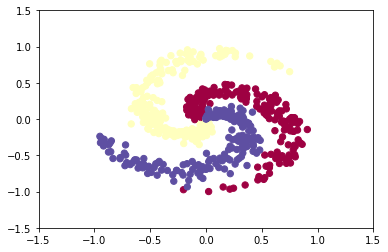

In [12]:
np.random.seed(999) #For reproducibility
[X,y] = toy_spiral3(200)
toy_plot(X,y)

**Code for training and inference of a 2-layer neural network**

In [13]:
class NN2LClassifier:

  def __init__(self, num_hidden=100, nclasses=3, ndims=2):
    self.nclasses = nclasses
    self.ndims = ndims
    self.h = num_hidden # size of hidden layer
    self.W1 = None
    self.b1 = None
    self.W2 = None
    self.b2 = None

  # Train the classifier's parameters
  def train(self, X, y, learning_rate=1e-0, reg_weight=1e-3, num_iters=10000, verbose=True):
    #Hyperparameters
    #learning_rate: gradient descent step size
    #reg_weight: regularization   
    N = X.shape[0] #number of data points
  
    # initialize parameters randomly
    self.W1 = 0.01 *np.random.randn(self.ndims,self.h) #NOTE: much faster if you remove 0.01 here
    self.b1 = np.zeros((1,self.h))
    self.W2 = 0.01 *np.random.randn(self.h,self.nclasses)
    self.b2 = np.zeros((1,self.nclasses))

    #Gradient descent 
    for i in range(num_iters):
  
      # evaluate class scores, [N x K]
      hidden = np.maximum(0, np.dot(X, self.W1) + self.b1) #ReLU activation
      scores = np.dot(hidden, self.W2) + self.b2
  
      # compute the class probabilities
      expo = np.exp(scores)
      softm = expo / np.sum(expo, axis=1, keepdims=True) # [N x K]
  
      # compute the loss: average cross-entropy loss and regularization
      logs = -np.log(softm[range(N),y])
      data_loss = np.sum(logs)/N
      reg_loss = 0.5*reg_weight*np.sum(self.W1*self.W1) + 0.5*reg_weight*np.sum(self.W2*self.W2)
      loss = data_loss + reg_loss

      # compute the gradient on scores
      dscores = softm
      dscores[range(N),y] -= 1
      dscores /= N
  
      # backpropate the gradient to the parameters
      # first backprop into parameters W2 and b2
      dW2 = np.dot(hidden.T, dscores)
      db2 = np.sum(dscores, axis=0, keepdims=True)
      # next backprop into hidden layer
      dhidden = np.dot(dscores, self.W2.T)
      # backprop the ReLU non-linearity
      dhidden[hidden <= 0] = 0
      # finally into W1,b1
      dW1 = np.dot(X.T, dhidden)
      db1 = np.sum(dhidden, axis=0, keepdims=True)
  
      # add regularization gradient contribution
      dW2 += reg_weight * self.W2
      dW1 += reg_weight * self.W1
  
      # perform a parameter update
      self.W1 += -learning_rate * dW1
      self.b1 += -learning_rate * db1
      self.W2 += -learning_rate * dW2
      self.b2 += -learning_rate * db2
      
      if verbose and (i % 50 == 0):   #Print loss every few steps
        print("iteration %d: loss=%f ; train_acc:%f" % (i, loss, self.accuracy(X,y)) )
      
    return self.accuracy(X,y)

  # predict the classes for all input
  def predict(self,X):
      scores = np.dot(np.maximum(0, np.dot(X, self.W1) + self.b1),self.W2) + self.b2
      predicted_classes = np.argmax(scores, axis=1)
      return predicted_classes
      
  # compute accuracy on x 
  def accuracy(self,X,y):
      predicted_classes = self.predict(X)
      accuracy = np.mean(predicted_classes == y)
      #print 'training accuracy: %.2f' % (accuracy)
      return accuracy


Training of the 2-layer neural network on the Spiral3 dataset 

In [14]:
classifier = NN2LClassifier(num_hidden=64)
training_acc = classifier.train(X,y,num_iters=3000,learning_rate=1,reg_weight=1e-3)
print('training accuracy: %.2f' %training_acc)

iteration 0: loss=1.098645 ; train_acc:0.521667
iteration 50: loss=0.765728 ; train_acc:0.551667
iteration 100: loss=0.723876 ; train_acc:0.566667
iteration 150: loss=0.701637 ; train_acc:0.581667
iteration 200: loss=0.730749 ; train_acc:0.638333
iteration 250: loss=0.725585 ; train_acc:0.661667
iteration 300: loss=0.694860 ; train_acc:0.668333
iteration 350: loss=0.607417 ; train_acc:0.761667
iteration 400: loss=0.516494 ; train_acc:0.786667
iteration 450: loss=0.496246 ; train_acc:0.808333
iteration 500: loss=0.447666 ; train_acc:0.826667
iteration 550: loss=0.425136 ; train_acc:0.860000
iteration 600: loss=0.407047 ; train_acc:0.865000
iteration 650: loss=0.387271 ; train_acc:0.875000
iteration 700: loss=0.376987 ; train_acc:0.885000
iteration 750: loss=0.363319 ; train_acc:0.898333
iteration 800: loss=0.354779 ; train_acc:0.903333
iteration 850: loss=0.349501 ; train_acc:0.908333
iteration 900: loss=0.343807 ; train_acc:0.915000
iteration 950: loss=0.337951 ; train_acc:0.915000
ite

Text(0, 0.5, 'Training accuracy')

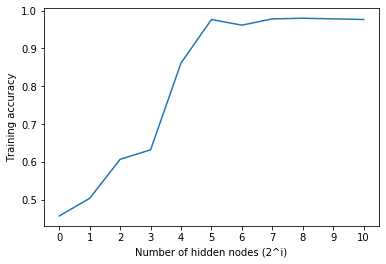

In [15]:
nb_iterations = 11
training_acc = np.zeros(nb_iterations)

for i in range(nb_iterations): 
  classifier = NN2LClassifier(num_hidden = 2**i)
  training_acc[i] = classifier.train(X,y,num_iters=3000,learning_rate=1,reg_weight=1e-3, verbose=False)

plt.plot(training_acc)
plt.xticks([i for i in range(0,nb_iterations)])
plt.xlabel('Number of hidden nodes (2^i)')
plt.ylabel('Training accuracy')

### Classification on MNIST

Loading the MNIST dataset (images of size 28x28):

In [19]:
path = os.getcwd() 
f = gzip.open(path+'/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f,encoding='bytes')
f.close()

X_train,y_train = train_set
X_test,y_test = test_set

inds=np.arange(0,X_train.shape[0])
np.random.shuffle(inds)
X_train,y_train = X_train[inds],y_train[inds] 

inds=np.arange(0,X_test.shape[0])
np.random.shuffle(inds)
X_test,y_test = X_test[inds],y_test[inds] 

print(X_train.shape)
print(X_test.shape)

(50000, 784)
(10000, 784)


Training of the classifier on MNIST dataset:

In [20]:
classifier = NN2LClassifier(nclasses=10,ndims=784)
training_acc = classifier.train(X_train,y_train, num_iters=1000)
print('training accuracy: %.2f' %training_acc)

iteration 0: loss=2.305921 ; train_acc:0.347140
iteration 50: loss=0.594064 ; train_acc:0.850260
iteration 100: loss=0.352126 ; train_acc:0.912480
iteration 150: loss=0.335262 ; train_acc:0.924560
iteration 200: loss=0.329126 ; train_acc:0.912600
iteration 250: loss=0.253397 ; train_acc:0.946180
iteration 300: loss=0.242472 ; train_acc:0.949640
iteration 350: loss=0.271987 ; train_acc:0.934660
iteration 400: loss=0.220808 ; train_acc:0.956460
iteration 450: loss=0.212413 ; train_acc:0.959600
iteration 500: loss=0.205883 ; train_acc:0.962200
iteration 550: loss=0.222668 ; train_acc:0.958160
iteration 600: loss=0.205258 ; train_acc:0.963260
iteration 650: loss=0.390037 ; train_acc:0.912480
iteration 700: loss=0.259373 ; train_acc:0.953120
iteration 750: loss=0.253063 ; train_acc:0.954320
iteration 800: loss=0.233449 ; train_acc:0.960400
iteration 850: loss=0.224191 ; train_acc:0.962800
iteration 900: loss=0.220142 ; train_acc:0.963380
iteration 950: loss=0.208803 ; train_acc:0.966800
tra

Testing on the test set:

In [21]:
test_acc = classifier.accuracy(X_test,y_test)
print('test accuracy: %.2f' %test_acc)

test accuracy: 0.96
